# Portfolio Accounting Engine
## Transaction-Driven Portfolio Accounting with Tax Handling & Dividend Reinvestment

**Architecture Overview:**
- All portfolio value flows from executed trades — no return-stream simulation
- Portfolio value = `sum(shares_held * current_price) + cash`
- FIFO lot disposal for capital gains
- Dividends trigger on PAYDATE only, taxed then reinvested as new trades
- Full separation of realized gains, taxes, and unrealized gains

## Section 1: Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Optional, Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# ── Tax Configuration ─────────────────────────────────────────────────────────
TAX_CONFIG = {
    'short_term_rate':  0.35,   # ordinary income rate
    'long_term_rate':   0.20,   # long-term capital gains rate
    'dividend_rate':    0.15,   # qualified dividend rate
    'lt_holding_days':  365,    # days required for long-term treatment
}

# ── Transaction Cost Configuration ────────────────────────────────────────────
COST_CONFIG = {
    'commission_per_share': 0.005,   # $ per share
    'slippage_bps':         5,       # basis points of trade value
}

## Section 1b: Data Loading & Filtering

Load your real `prices` and `dividends` DataFrames here.
Date columns arrive as strings (`'2022-01-03'`) and are parsed to `datetime64` below.

**Key optimization:** set `TRADING_IDS` to only the securities you are actually trading.
This filters the prices DataFrame down before it enters the engine, which is the
single biggest performance win on a large CSV.

**Expected schemas:**
- `prices`   → `TRADINGITEMID, TICKERSYMBOL, PRICEDATE, PRICECLOSE, VOLUME`
- `dividends` → `TRADINGITEMID, DIVIDENDID, EXDATE, PAYDATE, DIVAMOUNT`

In [2]:

# ╔══════════════════════════════════════════════════════════════════╗
# ║  Set the securities you are actually trading                     ║
# ║                                                                  ║
# ║  This is the most important performance setting. The engine      ║
# ║  only needs prices for securities in your portfolio. Filtering   ║
# ║  here cuts the prices DataFrame from millions of rows to         ║
# ║  potentially just thousands.                                     ║
# ║                                                                  ║
# ║  Set to None to load ALL securities (slow on large files).       ║
# ╚══════════════════════════════════════════════════════════════════╝

TRADING_IDS = [          # ← replace with your actual TRADINGITEMIDs
    37284811,
    39599142
]

# Optional: narrow the date window too (cuts rows further)
# Set to None to load the full history.
SIM_START = pd.Timestamp('2025-01-01')   # ← edit or set to None
SIM_END   = pd.Timestamp('2025-12-31')   # ← edit or set to None

# ╔══════════════════════════════════════════════════════════════════╗
# ║  LOADING LOGIC — no edits needed below this line                 ║
# ╚══════════════════════════════════════════════════════════════════╝

# ── Load raw data ─────────────────────────────────────────────────
# For CSV: use usecols to skip VOLUME if not needed (faster read)
_price_cols = ['TRADINGITEMID', 'TICKERSYMBOL', 'PRICEDATE', 'PRICECLOSE', 'VOLUME']
_div_cols   = ['TRADINGITEMID', 'DIVIDENDID', 'EXDATE', 'PAYDATE', 'DIVAMOUNT']

prices    = pd.read_csv("price_data (1).csv",    usecols=_price_cols)
dividends = pd.read_csv("dividend_data (1).csv", usecols=_div_cols)

# ── Date Parsing ─────────────────────────────────────────────────
prices['PRICEDATE']  = pd.to_datetime(prices['PRICEDATE'],  infer_datetime_format=True, utc=False)
dividends['EXDATE']  = pd.to_datetime(dividends['EXDATE'],  infer_datetime_format=True, utc=False)
dividends['PAYDATE'] = pd.to_datetime(dividends['PAYDATE'], infer_datetime_format=True, utc=False)

for col in ['PRICEDATE']:
    if prices[col].dt.tz is not None:
        prices[col] = prices[col].dt.tz_localize(None)
for col in ['EXDATE', 'PAYDATE']:
    if dividends[col].dt.tz is not None:
        dividends[col] = dividends[col].dt.tz_localize(None)

# ── Type Enforcement ──────────────────────────────────────────────
prices['TRADINGITEMID']    = prices['TRADINGITEMID'].astype(int)
prices['PRICECLOSE']       = prices['PRICECLOSE'].astype(float)
prices['VOLUME']           = pd.to_numeric(prices['VOLUME'], errors='coerce').fillna(0).astype(int)
dividends['TRADINGITEMID'] = dividends['TRADINGITEMID'].astype(int)
dividends['DIVAMOUNT']     = dividends['DIVAMOUNT'].astype(float)

# ── FILTER 1: Keep only securities you are trading ───────────────
# This is the single biggest speedup — drop every stock you don't own.
if TRADING_IDS:
    _before = len(prices)
    prices    = prices[prices['TRADINGITEMID'].isin(TRADING_IDS)].copy()
    dividends = dividends[dividends['TRADINGITEMID'].isin(TRADING_IDS)].copy()
    print(f'Securities filter: {_before:,} → {len(prices):,} price rows '
          f'({100*len(prices)/_before:.1f}% kept)')

# ── FILTER 2: Trim to simulation date window ──────────────────────
# Keep a small buffer before SIM_START so _last_price_lookup can
# always find a valid prior close (e.g. if SIM_START is a holiday).
_buffer = pd.Timedelta(days=10)
if SIM_START is not None:
    prices    = prices[prices['PRICEDATE']  >= SIM_START - _buffer].copy()
    dividends = dividends[dividends['PAYDATE'] >= SIM_START - _buffer].copy()
if SIM_END is not None:
    prices    = prices[prices['PRICEDATE']  <= SIM_END].copy()
    dividends = dividends[dividends['PAYDATE'] <= SIM_END].copy()

# ── Deduplication ─────────────────────────────────────────────────
prices = prices.sort_values('PRICEDATE').drop_duplicates(
    subset=['TRADINGITEMID', 'PRICEDATE'], keep='last'
).reset_index(drop=True)

# ── Derive final simulation window from filtered data ─────────────
if SIM_START is None:
    SIM_START = prices['PRICEDATE'].min()
if SIM_END is None:
    SIM_END = prices['PRICEDATE'].max()

# ── Sanity Check ─────────────────────────────────────────────────
print('── prices (filtered) ───────────────────────')
print(f'  Rows:       {len(prices):,}')
print(f'  Securities: {prices["TRADINGITEMID"].nunique()}')
print(f'  Date range: {prices["PRICEDATE"].min().date()} → {prices["PRICEDATE"].max().date()}')
print(f'  Null closes: {prices["PRICECLOSE"].isna().sum()}')
print()
print('── dividends (filtered) ────────────────────')
print(f'  Rows:       {len(dividends):,}')
print(f'  Securities: {dividends["TRADINGITEMID"].nunique()}')
print()
print(f'Simulation window: {SIM_START.date()} → {SIM_END.date()}')

Securities filter: 2,430,383 → 11,126 price rows (0.5% kept)
── prices (filtered) ───────────────────────
  Rows:       512
  Securities: 2
  Date range: 2024-12-23 → 2025-12-31
  Null closes: 0

── dividends (filtered) ────────────────────
  Rows:       19
  Securities: 2

Simulation window: 2025-01-01 → 2025-12-31


In [3]:
# ── Optional: Preview ─────────────────────────────────────────────
print('prices sample:')
display(prices.head(3))
print('dividends sample:')
display(dividends.head(3))

prices sample:


,TRADINGITEMID,TICKERSYMBOL,PRICEDATE,PRICECLOSE,VOLUME
0,37284811,SPYV,2024-12-23,51.47,2894040
1,39599142,EMB,2024-12-23,89.33,4949102
2,39599142,EMB,2024-12-24,89.73,2512536


dividends sample:


,DIVIDENDID,EXDATE,PAYDATE,DIVAMOUNT,TRADINGITEMID
338,10562538,2025-12-22,2025-12-24,0.313844,37284811
468,10554982,2025-12-19,2025-12-24,0.382893,39599142
869,10504765,2025-12-01,2025-12-04,0.372202,39599142


In [4]:
# SIM_START and SIM_END are now set in the loading cell above.
# Re-run that cell if you change them.
print(f'Simulation window: {SIM_START.date()} → {SIM_END.date()}')

Simulation window: 2025-01-01 → 2025-12-31


> **Next step:** scroll to Section 9 (Example Usage) and define your `scheduled_trades` DataFrame,
> then run the engine with `SIM_START` / `SIM_END`.

## Section 2: Data Structures

In [5]:
# ── Lot Schema ─────────────────────────────────────────────────────────────────
LOT_COLUMNS = [
    'lot_id',           # unique lot identifier
    'tradingitemid',
    'tickersymbol',
    'open_date',        # trade date lot was created
    'shares',           # remaining shares in lot
    'cost_basis',       # per-share cost basis (incl. transaction costs)
    'total_cost',       # shares * cost_basis
    'source',           # 'BUY' | 'DRIP'
]

# ── Trade Ledger Schema ────────────────────────────────────────────────────────
TRADE_COLUMNS = [
    'trade_id',
    'trade_date',
    'tradingitemid',
    'tickersymbol',
    'action',           # 'BUY' | 'SELL' | 'DRIP'
    'shares',
    'price',            # execution price (post-slippage)
    'gross_value',
    'commission',
    'net_cash_impact',  # negative = cash out, positive = cash in
]

# ── Realized Gains Ledger Schema ───────────────────────────────────────────────
REALIZED_COLUMNS = [
    'event_id',
    'event_date',
    'tradingitemid',
    'tickersymbol',
    'event_type',       # 'SALE' | 'DIVIDEND'
    'shares',
    'proceeds',
    'cost_basis',
    'gain_loss',
    'holding_days',
    'gain_type',        # 'ST' | 'LT' | 'DIVIDEND'
    'tax_rate',
    'tax_owed',
    'lot_id',
]

## Section 3: Tax Engine

In [6]:
class TaxEngine:
    """
    Computes tax liability on realized capital gains and dividends.

    Rules
    -----
    - Short-term: holding period < lt_holding_days
    - Long-term:  holding period >= lt_holding_days
    - Dividend:   fixed qualified dividend rate
    - Taxes only triggered on realization events (sale or dividend pay)
    - Realized losses accumulate in a carry-forward balance that offsets
      future gains before tax is computed (ST losses offset ST gains first,
      then spill into LT; LT losses offset LT gains first, then spill into ST)
    """

    def __init__(self, config: dict = TAX_CONFIG):
        self.st_rate  = config['short_term_rate']
        self.lt_rate  = config['long_term_rate']
        self.div_rate = config['dividend_rate']
        self.lt_days  = config['lt_holding_days']

        # ── Loss Carry-Forward Balances ───────────────────────────────────────
        # Stored as positive numbers representing loss available to offset gains.
        self.st_loss_carryforward: float = 0.0
        self.lt_loss_carryforward: float = 0.0

    def classify_holding(self, open_date: pd.Timestamp, close_date: pd.Timestamp) -> Tuple[str, float]:
        """
        Determine whether a lot qualifies for long-term treatment.

        Parameters
        ----------
        open_date  : date lot was opened
        close_date : date of sale

        Returns
        -------
        (gain_type, tax_rate)
        """
        holding_days = (close_date - open_date).days
        if holding_days >= self.lt_days:
            return 'LT', self.lt_rate
        return 'ST', self.st_rate

    def compute_sale_tax(self, gain: float, gain_type: str) -> float:
        """
        Compute tax owed on a realized gain, net of any loss carry-forwards.

        Loss netting rules
        ------------------
        - ST losses offset ST gains first; any excess offsets LT gains.
        - LT losses offset LT gains first; any excess offsets ST gains.
        - New losses (gain < 0) are added to the appropriate carry-forward
          bucket for use against future gains.
        - Carry-forwards persist for the lifetime of the TaxEngine instance
          (i.e. across the full simulation). Extend with annual reset logic
          if strict calendar-year carry-forward rules are required.

        Returns
        -------
        tax_owed (float) — always >= 0
        """
        if gain < 0:
            # Accumulate loss in the appropriate bucket
            loss = abs(gain)
            if gain_type == 'ST':
                self.st_loss_carryforward += loss
            else:
                self.lt_loss_carryforward += loss
            return 0.0

        if gain == 0:
            return 0.0

        # ── Net gain against same-type carry-forward first, then cross-type ──
        taxable = gain
        if gain_type == 'ST':
            # 1. Use ST carry-forward
            used_st = min(taxable, self.st_loss_carryforward)
            taxable -= used_st
            self.st_loss_carryforward -= used_st
            # 2. Use remaining LT carry-forward
            used_lt = min(taxable, self.lt_loss_carryforward)
            taxable -= used_lt
            self.lt_loss_carryforward -= used_lt
            rate = self.st_rate
        else:  # LT
            # 1. Use LT carry-forward
            used_lt = min(taxable, self.lt_loss_carryforward)
            taxable -= used_lt
            self.lt_loss_carryforward -= used_lt
            # 2. Use remaining ST carry-forward
            used_st = min(taxable, self.st_loss_carryforward)
            taxable -= used_st
            self.st_loss_carryforward -= used_st
            rate = self.lt_rate

        return taxable * rate

    @property
    def total_loss_carryforward(self) -> float:
        """Total unused loss carry-forward across both buckets."""
        return self.st_loss_carryforward + self.lt_loss_carryforward

    def compute_dividend_tax(self, gross_dividend: float) -> Tuple[float, float]:
        """
        Compute dividend tax.

        Returns
        -------
        (tax_owed, after_tax_dividend)
        """
        tax = gross_dividend * self.div_rate
        return tax, gross_dividend - tax

## Section 4: Transaction Cost Engine

In [7]:
class TransactionCostEngine:
    """
    Applies commission and slippage to trades.

    Slippage model: execution price moves against you by `slippage_bps` basis points.
    - Buys:  price * (1 + slippage_bps / 10000)
    - Sells: price * (1 - slippage_bps / 10000)
    """

    def __init__(self, config: dict = COST_CONFIG):
        self.commission_per_share = config['commission_per_share']
        self.slippage_bps = config['slippage_bps']

    def apply(self, action: str, shares: float, base_price: float) -> Dict:
        """
        Compute all-in execution cost for a trade.

        Parameters
        ----------
        action     : 'BUY' | 'SELL' | 'DRIP'
        shares     : number of shares
        base_price : mid-market price

        Returns
        -------
        dict with keys: exec_price, gross_value, commission, net_cash_impact
        """
        slip = self.slippage_bps / 10_000
        if action in ('BUY', 'DRIP'):
            exec_price = base_price * (1 + slip)
        else:
            exec_price = base_price * (1 - slip)

        gross_value = shares * exec_price
        commission  = shares * self.commission_per_share

        if action in ('BUY', 'DRIP'):
            net_cash_impact = -(gross_value + commission)   # cash out
        else:
            net_cash_impact = gross_value - commission      # cash in

        return {
            'exec_price':     exec_price,
            'gross_value':    gross_value,
            'commission':     commission,
            'net_cash_impact': net_cash_impact,
        }

## Section 5: Portfolio Class

In [8]:
class Portfolio:
    """
    Trade-driven portfolio accounting engine.

    State
    -----
    cash           : current cash balance
    lots           : DataFrame of open lots
    trades_ledger  : immutable record of all executed trades
    realized_ledger: record of all realization events (sales + dividends)
    taxes_ledger   : running record of taxes deducted from cash
    nav_history    : daily NAV time series

    Design Decisions
    ----------------
    - Lot disposal order is controlled by `lot_selection` on each sell() call.
      Supported modes:
        'FIFO'        — oldest lot first (default, most common)
        'LIFO'        — newest lot first
        'TAX_OPTIMAL' — minimize tax by preferring loss lots first (largest
                        loss first), then lowest-gain lots. Within losses,
                        short-term losses are preferred over long-term because
                        they offset higher-rate gains.
    - Cost basis includes slippage and commission (total acquisition cost).
    - Taxes are deducted from cash immediately on realization.
    - Loss carry-forwards live in TaxEngine and persist across the simulation.
    """

    def __init__(
        self,
        initial_cash: float,
        tax_config: dict = TAX_CONFIG,
        cost_config: dict = COST_CONFIG,
    ):
        self.cash     = initial_cash
        self.tax_eng  = TaxEngine(tax_config)
        self.cost_eng = TransactionCostEngine(cost_config)

        # ── Internal State ────────────────────────────────────────────────────
        self._lot_counter     = 0
        self._trade_counter   = 0
        self._realized_counter = 0

        # ── Append buffers — accumulate rows as plain dicts, materialize to
        #    DataFrame on access. Avoids O(n²) pd.concat row-by-row pattern.
        self._lots_buf     = []
        self._trades_buf   = []
        self._realized_buf = []
        self._taxes_buf    = []
        # Per-security lot index: tradingitemid → list of _lots_buf indices
        # Avoids scanning the full lots DataFrame on every sell/dividend.
        self._lots_idx: dict = {}
        # Reverse map: lot_id → index in _lots_buf for O(1) sell updates
        self._lot_id_to_buf: dict = {}

        self.lots             = pd.DataFrame(columns=LOT_COLUMNS)
        self.trades_ledger    = pd.DataFrame(columns=TRADE_COLUMNS)
        self.realized_ledger  = pd.DataFrame(columns=REALIZED_COLUMNS)
        self.taxes_paid       = pd.DataFrame(columns=['date', 'event_id', 'tax_type', 'amount'])
        self.nav_history      = pd.DataFrame(columns=[
            'date', 'portfolio_value', 'cash', 'market_value',
            'daily_return', 'unrealized_gain', 'realized_ytd', 'taxes_ytd'
        ])

    # ──────────────────────────────────────────────────────────────────────────
    # Internal Helpers
    # ──────────────────────────────────────────────────────────────────────────

    def _next_lot_id(self) -> str:
        self._lot_counter += 1
        return f'LOT{self._lot_counter:05d}'

    def _next_trade_id(self) -> str:
        self._trade_counter += 1
        return f'TRD{self._trade_counter:05d}'

    def _next_realized_id(self) -> str:
        self._realized_counter += 1
        return f'REL{self._realized_counter:05d}'

    def _open_lots_for(self, tradingitemid: int) -> pd.DataFrame:
        """Return open lots for a security, FIFO-ordered (oldest first).
        Uses _lots_idx for O(k) lookup (k = lots for this security)
        instead of scanning the full lots DataFrame.
        """
        indices = self._lots_idx.get(tradingitemid, [])
        if not indices:
            return pd.DataFrame(columns=LOT_COLUMNS)
        rows = [self._lots_buf[i] for i in indices
                if self._lots_buf[i]['shares'] > 1e-9]
        if not rows:
            return pd.DataFrame(columns=LOT_COLUMNS)
        return pd.DataFrame(rows).sort_values('open_date')

    def _sort_lots_for_disposal(
        self,
        tradingitemid: int,
        current_price: float,
        sale_date: pd.Timestamp,
        lot_selection: str,
    ) -> pd.DataFrame:
        """
        Return open lots sorted according to the chosen disposal strategy.

        Parameters
        ----------
        lot_selection : 'FIFO' | 'LIFO' | 'TAX_OPTIMAL'

        TAX_OPTIMAL ordering
        --------------------
        Priority 1 — Loss lots first (largest loss per share first).
                     Within loss lots, ST losses before LT losses because
                     ST losses offset higher-taxed ST gains.
        Priority 2 — Gain lots last (smallest gain per share first to defer
                     the largest taxable events as long as possible).
        """
        open_lots = self._open_lots_for(tradingitemid).copy()
        if open_lots.empty:
            return open_lots

        if lot_selection == 'FIFO':
            return open_lots.sort_values('open_date', ascending=True)

        if lot_selection == 'LIFO':
            return open_lots.sort_values('open_date', ascending=False)

        if lot_selection == 'TAX_OPTIMAL':
            open_lots['unrealized_pnl_per_share'] = current_price - open_lots['cost_basis']
            open_lots['holding_days'] = (sale_date - open_lots['open_date']).dt.days
            open_lots['is_lt'] = (open_lots['holding_days'] >= self.tax_eng.lt_days).astype(int)
            open_lots['is_loss'] = (open_lots['unrealized_pnl_per_share'] < 0).astype(int)

            # Sort: losses first (is_loss DESC), then ST before LT within losses
            # (is_lt ASC within losses), then by pnl ascending (biggest loss
            # first, smallest gain first among gainers).
            open_lots = open_lots.sort_values(
                ['is_loss', 'is_lt', 'unrealized_pnl_per_share'],
                ascending=[False, True, True],
            )
            return open_lots

        raise ValueError(f"Unknown lot_selection: {lot_selection!r}. Use 'FIFO', 'LIFO', or 'TAX_OPTIMAL'.")

    def _shares_held(self, tradingitemid: int) -> float:
        """Total shares held — sums directly from _lots_buf, no DataFrame needed."""
        indices = self._lots_idx.get(tradingitemid, [])
        return sum(self._lots_buf[i]['shares'] for i in indices
                   if self._lots_buf[i]['shares'] > 1e-9)

    def _record_tax(self, date: pd.Timestamp, event_id: str, tax_type: str, amount: float):
        """Deduct tax from cash and log the event."""
        if amount <= 0:
            return
        self.cash -= amount
        self._taxes_buf.append({'date': date, 'event_id': event_id, 'tax_type': tax_type, 'amount': amount})
        self.taxes_paid = pd.DataFrame(self._taxes_buf)

    # ──────────────────────────────────────────────────────────────────────────
    # Trade Execution
    # ──────────────────────────────────────────────────────────────────────────

    def buy(
        self,
        date: pd.Timestamp,
        tradingitemid: int,
        tickersymbol: str,
        shares: float,
        price: float,
        source: str = 'BUY',
    ) -> Optional[str]:
        """
        Execute a buy order.

        Parameters
        ----------
        source : 'BUY' for manual trades, 'DRIP' for dividend reinvestment

        Returns
        -------
        lot_id or None if insufficient cash
        """
        costs = self.cost_eng.apply(source, shares, price)

        # Guard: insufficient cash
        if self.cash + costs['net_cash_impact'] < 0:
            warnings.warn(f"[{date.date()}] Insufficient cash for {source} {shares:.2f} {tickersymbol}. Skipping.")
            return None

        # Cost basis = total acquisition cost per share (incl. slippage + commission)
        cost_basis = (costs['gross_value'] + costs['commission']) / shares

        # Record trade
        trade_id = self._next_trade_id()
        trade_row = pd.DataFrame([{
            'trade_id':        trade_id,
            'trade_date':      date,
            'tradingitemid':   tradingitemid,
            'tickersymbol':    tickersymbol,
            'action':          source,
            'shares':          shares,
            'price':           costs['exec_price'],
            'gross_value':     costs['gross_value'],
            'commission':      costs['commission'],
            'net_cash_impact': costs['net_cash_impact'],
        }])
        self._trades_buf.append(trade_row.iloc[0].to_dict())
        self.trades_ledger = pd.DataFrame(self._trades_buf)

        # Open new lot
        lot_id = self._next_lot_id()
        new_lot = {
            'lot_id':        lot_id,
            'tradingitemid': tradingitemid,
            'tickersymbol':  tickersymbol,
            'open_date':     date,
            'shares':        shares,
            'cost_basis':    cost_basis,
            'total_cost':    shares * cost_basis,
            'source':        source,
        }
        buf_pos = len(self._lots_buf)
        self._lots_buf.append(new_lot)
        self._lots_idx.setdefault(tradingitemid, []).append(buf_pos)
        self._lot_id_to_buf[lot_id] = buf_pos
        self.lots = pd.DataFrame(self._lots_buf)

        # Update cash
        self.cash += costs['net_cash_impact']

        return lot_id

    def sell(
        self,
        date: pd.Timestamp,
        tradingitemid: int,
        tickersymbol: str,
        shares: float,
        price: float,
        lot_selection: str = 'FIFO',
    ) -> bool:
        """
        Execute a sell order.

        Parameters
        ----------
        lot_selection : 'FIFO' | 'LIFO' | 'TAX_OPTIMAL'
            Controls which lots are disposed of first.
            - 'FIFO'        : oldest lot first (default)
            - 'LIFO'        : newest lot first
            - 'TAX_OPTIMAL' : prioritises loss lots (largest ST loss first)
                              to harvest losses and build carry-forward balance;
                              defers low-basis gain lots as long as possible.

        Returns
        -------
        True if fully executed, False if insufficient shares
        """
        available = self._shares_held(tradingitemid)
        if shares > available + 1e-9:
            warnings.warn(
                f"[{date.date()}] Tried to sell {shares:.4f} {tickersymbol} "
                f"but only {available:.4f} held. Clamping to available."
            )
            shares = available
        if shares <= 1e-9:
            return False

        costs = self.cost_eng.apply('SELL', shares, price)

        # Check: transaction cost > proceeds
        if costs['net_cash_impact'] <= 0:
            warnings.warn(f"[{date.date()}] Sell proceeds < transaction costs for {tickersymbol}. Aborting.")
            return False

        # Record trade
        trade_id = self._next_trade_id()
        trade_row = pd.DataFrame([{
            'trade_id':        trade_id,
            'trade_date':      date,
            'tradingitemid':   tradingitemid,
            'tickersymbol':    tickersymbol,
            'action':          'SELL',
            'shares':          shares,
            'price':           costs['exec_price'],
            'gross_value':     costs['gross_value'],
            'commission':      costs['commission'],
            'net_cash_impact': costs['net_cash_impact'],
        }])
        self._trades_buf.append(trade_row.iloc[0].to_dict())
        self.trades_ledger = pd.DataFrame(self._trades_buf)

        # Lot disposal — order determined by lot_selection
        shares_to_sell   = shares
        proceeds_per_sh  = costs['net_cash_impact'] / shares  # net proceeds per share

        ordered_lots = self._sort_lots_for_disposal(
            tradingitemid, price, date, lot_selection
        )

        for idx, lot in ordered_lots.iterrows():
            if shares_to_sell <= 1e-9:
                break

            lot_shares = lot['shares']
            sold_from_lot = min(lot_shares, shares_to_sell)

            gain_type, tax_rate = self.tax_eng.classify_holding(lot['open_date'], date)
            holding_days = (date - lot['open_date']).days

            proceeds_this   = sold_from_lot * proceeds_per_sh
            cost_this       = sold_from_lot * lot['cost_basis']
            gain_this       = proceeds_this - cost_this
            # compute_sale_tax now handles carry-forward netting internally
            tax_this        = self.tax_eng.compute_sale_tax(gain_this, gain_type)

            # Log realized event
            event_id = self._next_realized_id()
            rel_row = pd.DataFrame([{
                'event_id':     event_id,
                'event_date':   date,
                'tradingitemid': tradingitemid,
                'tickersymbol': tickersymbol,
                'event_type':   'SALE',
                'shares':       sold_from_lot,
                'proceeds':     proceeds_this,
                'cost_basis':   cost_this,
                'gain_loss':    gain_this,
                'holding_days': holding_days,
                'gain_type':    gain_type,
                'tax_rate':     tax_rate,
                'tax_owed':     tax_this,
                'lot_id':       lot['lot_id'],
            }])
            self._realized_buf.append(rel_row.iloc[0].to_dict())
            self.realized_ledger = pd.DataFrame(self._realized_buf)

            # Deduct tax from cash
            self._record_tax(date, event_id, gain_type + '_GAIN', tax_this)

            # Update lot in both _lots_buf (source of truth) and the
            # materialized DataFrame so both stay consistent.
            remaining_shares = lot_shares - sold_from_lot
            remaining_cost   = remaining_shares * lot['cost_basis']
            # O(1) update via reverse map lot_id → buf index
            _bi = self._lot_id_to_buf[lot['lot_id']]
            self._lots_buf[_bi]['shares']     = remaining_shares
            self._lots_buf[_bi]['total_cost'] = remaining_cost
            self.lots.at[idx, 'shares']     = remaining_shares
            self.lots.at[idx, 'total_cost'] = remaining_cost

            shares_to_sell -= sold_from_lot

        # Update cash (add sale proceeds)
        self.cash += costs['net_cash_impact']

        return True

    # ──────────────────────────────────────────────────────────────────────────
    # Dividend Processing
    # ──────────────────────────────────────────────────────────────────────────

    def process_dividend(
        self,
        pay_date: pd.Timestamp,
        tradingitemid: int,
        tickersymbol: str,
        div_amount_per_share: float,
        reinvest_price: float,
    ):
        """
        Process a dividend payment and reinvest after-tax proceeds.

        Steps
        -----
        1. Compute gross dividend from shares held at PAYDATE
        2. Apply dividend tax → cash temporarily (we'll then reinvest)
        3. Record dividend realization event
        4. Execute DRIP buy for after-tax amount

        Notes
        -----
        - Does NOT inject cash directly into portfolio — flows through a DRIP trade.
        - reinvest_price should be the last available close on or before pay_date.
        - If shares_held == 0, silently skips.
        """
        shares_held = self._shares_held(tradingitemid)
        if shares_held <= 1e-9:
            return

        gross_div = shares_held * div_amount_per_share
        tax_owed, after_tax_div = self.tax_eng.compute_dividend_tax(gross_div)

        # Log realized dividend event
        event_id = self._next_realized_id()
        rel_row = pd.DataFrame([{
            'event_id':     event_id,
            'event_date':   pay_date,
            'tradingitemid': tradingitemid,
            'tickersymbol': tickersymbol,
            'event_type':   'DIVIDEND',
            'shares':       shares_held,
            'proceeds':     gross_div,
            'cost_basis':   0.0,
            'gain_loss':    gross_div,
            'holding_days': np.nan,
            'gain_type':    'DIVIDEND',
            'tax_rate':     self.tax_eng.div_rate,
            'tax_owed':     tax_owed,
            'lot_id':       None,
        }])
        self._realized_buf.append(rel_row.iloc[0].to_dict())
        self.realized_ledger = pd.DataFrame(self._realized_buf)

        # Add gross dividend cash first, then deduct tax
        self.cash += gross_div
        self._record_tax(pay_date, event_id, 'DIVIDEND', tax_owed)

        # Reinvest after-tax dividend
        if reinvest_price > 0 and after_tax_div > 0:
            drip_shares = after_tax_div / reinvest_price
            self.buy(
                date=pay_date,
                tradingitemid=tradingitemid,
                tickersymbol=tickersymbol,
                shares=drip_shares,
                price=reinvest_price,
                source='DRIP',
            )

    # ──────────────────────────────────────────────────────────────────────────
    # Valuation
    # ──────────────────────────────────────────────────────────────────────────

    def market_value(self, price_lookup: Dict[int, float]) -> float:
        """
        Compute total market value of all open positions.

        Parameters
        ----------
        price_lookup : {tradingitemid: last_available_price}
        """
        if self.lots.empty:
            return 0.0
        open_lots = self.lots[self.lots['shares'] > 1e-9].copy()
        open_lots['price'] = open_lots['tradingitemid'].map(price_lookup).fillna(0)
        return (open_lots['shares'] * open_lots['price']).sum()

    def unrealized_gain(self, price_lookup: Dict[int, float]) -> float:
        """Total unrealized gain across all open positions."""
        if self.lots.empty:
            return 0.0
        open_lots = self.lots[self.lots['shares'] > 1e-9].copy()
        open_lots['price'] = open_lots['tradingitemid'].map(price_lookup).fillna(0)
        open_lots['mkt_val'] = open_lots['shares'] * open_lots['price']
        return (open_lots['mkt_val'] - open_lots['total_cost']).sum()

    def portfolio_value(self, price_lookup: Dict[int, float]) -> float:
        """Total portfolio value = market value of positions + cash."""
        return self.market_value(price_lookup) + self.cash

    def realized_ytd(self, year: int) -> float:
        """Total realized gain/loss YTD for a given year."""
        if self.realized_ledger.empty:
            return 0.0
        mask = self.realized_ledger['event_date'].dt.year == year
        return self.realized_ledger[mask]['gain_loss'].sum()

    def taxes_ytd(self, year: int) -> float:
        """Total taxes paid YTD for a given year."""
        if self.taxes_paid.empty:
            return 0.0
        mask = self.taxes_paid['date'].dt.year == year
        return self.taxes_paid[mask]['amount'].sum()

## Section 6: Daily Valuation Engine

In [9]:
class DailyValuationEngine:
    """
    Drives the portfolio forward day-by-day.

    Steps per day
    -------------
    1. Build price lookup from last available close (no look-ahead bias)
    2. Process any dividends with PAYDATE == today
    3. Execute any scheduled trades for today
    4. Compute and record NAV

    Assumptions
    -----------
    - Dividends are processed at open (before trades) on PAYDATE.
    - Scheduled trades execute at close price with slippage.
    - For dividend reinvestment, the last available close is used.
    - No intraday sequencing — all events on a given date share the same price.
    """

    def __init__(
        self,
        portfolio: Portfolio,
        prices: pd.DataFrame,
        dividends: pd.DataFrame,
    ):
        self.pf        = portfolio
        self.dividends = dividends.copy()
        self.dividends['PAYDATE'] = pd.to_datetime(self.dividends['PAYDATE'])
        self.dividends['EXDATE']  = pd.to_datetime(self.dividends['EXDATE'])

        # Ticker map: TRADINGITEMID → TICKERSYMBOL
        self._ticker_map = (
            prices[['TRADINGITEMID', 'TICKERSYMBOL']]
            .drop_duplicates()
            .set_index('TRADINGITEMID')['TICKERSYMBOL']
            .to_dict()
        )

        # ── Pre-build forward-filled price table (built ONCE) ─────────────
        # Old approach: filter + sort + groupby the full prices DataFrame on
        #   *every single trading day* → O(days × rows), catastrophic at scale.
        # New approach: pivot to (date × security) matrix, forward-fill once,
        #   then each day's lookup is a single O(1) .loc[] row access.
        _p = prices[['PRICEDATE', 'TRADINGITEMID', 'PRICECLOSE']].copy()
        _p['PRICEDATE'] = pd.to_datetime(_p['PRICEDATE'])

        pivot = _p.pivot_table(
            index='PRICEDATE',
            columns='TRADINGITEMID',
            values='PRICECLOSE',
            aggfunc='last',
        )
        # Reindex to every calendar day then forward-fill.
        # This propagates Friday's close into Saturday/Sunday and handles
        # dividend pay dates that fall on holidays — no special-casing needed.
        full_idx = pd.date_range(pivot.index.min(), pivot.index.max(), freq='D')
        self._price_table = pivot.reindex(full_idx).ffill()

        # ── Pre-index dividends by pay date (O(1) per day) ────────────────
        self._div_by_date = (
            self.dividends
            .groupby('PAYDATE')
            .apply(lambda df: df.to_dict('records'))
            .to_dict()
        )

        # Nav buffer — same list-based pattern as Portfolio ledgers
        self._nav_buf = []

    def _last_price_lookup(self, as_of: pd.Timestamp) -> Dict[int, float]:
        """
        O(1) price lookup — reads one row from the pre-built forward-filled
        pivot table. The ffill() in __init__ means every calendar date already
        carries the last known close for each security. No filter, no groupby.
        """
        tbl = self._price_table
        if as_of < tbl.index[0]:
            return {}
        key = min(as_of, tbl.index[-1])
        return tbl.loc[key].dropna().to_dict()

    def _get_dividends_on(self, date: pd.Timestamp) -> list:
        """O(1) dividend lookup from pre-indexed dict."""
        return self._div_by_date.get(date, [])

    def run(
        self,
        start_date: pd.Timestamp,
        end_date: pd.Timestamp,
        scheduled_trades: Optional[pd.DataFrame] = None,
    ) -> pd.DataFrame:
        """
        Run the daily valuation loop.

        Parameters
        ----------
        start_date       : first date to simulate
        end_date         : last date to simulate
        scheduled_trades : optional DataFrame with columns:
                           [trade_date, tradingitemid, action, shares, price_override]
                           price_override=NaN means use market price

        Returns
        -------
        nav_history DataFrame
        """
        trading_days = pd.bdate_range(start_date, end_date)
        prev_value   = None

        for day in trading_days:
            price_lookup = self._last_price_lookup(day)

            # ── 1. Process Dividends ──────────────────────────────────────────
            divs_today = self._get_dividends_on(day)
            for div in divs_today:
                tid    = div['TRADINGITEMID']
                ticker = self._ticker_map.get(tid, str(tid))
                rprice = price_lookup.get(tid, 0)
                if rprice > 0:
                    self.pf.process_dividend(
                        pay_date=day,
                        tradingitemid=tid,
                        tickersymbol=ticker,
                        div_amount_per_share=div['DIVAMOUNT'],
                        reinvest_price=rprice,
                    )

            # ── 2. Execute Scheduled Trades ───────────────────────────────────
            if scheduled_trades is not None:
                todays_trades = scheduled_trades[
                    scheduled_trades['trade_date'] == day
                ]
                for _, tr in todays_trades.iterrows():
                    tid    = tr['tradingitemid']
                    ticker = self._ticker_map.get(tid, str(tid))
                    price  = tr.get('price_override')
                    if pd.isna(price):
                        price = price_lookup.get(tid)
                    if price is None:
                        warnings.warn(f"[{day.date()}] No price for {ticker} on trade date. Skipping.")
                        continue

                    # lot_selection column is optional — defaults to FIFO
                    ls = tr.get('lot_selection', 'FIFO')
                    if not isinstance(ls, str) or pd.isna(ls):
                        ls = 'FIFO'

                    # ── Resolve shares vs cash_amount ──────────────────────
                    # cash_amount takes priority if provided and non-NaN.
                    # shares = cash_amount / execution_price (fractional OK).
                    raw_shares    = tr.get('shares',      np.nan)
                    raw_cash      = tr.get('cash_amount', np.nan)

                    try:
                        has_cash   = raw_cash is not None and not pd.isna(raw_cash) and float(raw_cash) > 0
                    except (TypeError, ValueError):
                        has_cash   = False
                    try:
                        has_shares = raw_shares is not None and not pd.isna(raw_shares) and float(raw_shares) > 0
                    except (TypeError, ValueError):
                        has_shares = False

                    if not has_cash and not has_shares:
                        warnings.warn(f"[{day.date()}] Trade for {ticker} has neither shares nor cash_amount. Skipping.")
                        continue

                    if has_cash:
                        # Convert dollar amount to shares using execution price
                        # (apply same slippage direction as the actual trade)
                        slip = self.pf.cost_eng.slippage_bps / 10_000
                        if tr['action'] == 'BUY':
                            exec_price_est = price * (1 + slip)
                        else:
                            exec_price_est = price * (1 - slip)
                        trade_shares = float(raw_cash) / exec_price_est
                    else:
                        trade_shares = float(raw_shares)

                    if tr['action'] == 'BUY':
                        self.pf.buy(day, tid, ticker, trade_shares, price)
                    elif tr['action'] == 'SELL':
                        self.pf.sell(day, tid, ticker, trade_shares, price, lot_selection=ls)

            # ── 3. Refresh Price Lookup Post-Trades ───────────────────────────
            # (DRIP trades may have shifted cash; price hasn't changed same day)
            price_lookup = self._last_price_lookup(day)

            # ── 4. Compute and Record NAV ─────────────────────────────────────
            mkt_val = self.pf.market_value(price_lookup)
            pf_val  = mkt_val + self.pf.cash
            unreal  = self.pf.unrealized_gain(price_lookup)
            real_ytd = self.pf.realized_ytd(day.year)
            tax_ytd  = self.pf.taxes_ytd(day.year)

            if prev_value is not None and prev_value > 0:
                daily_ret = (pf_val - prev_value) / prev_value
            else:
                daily_ret = np.nan

            nav_row = pd.DataFrame([{
                'date':            day,
                'portfolio_value': pf_val,
                'cash':            self.pf.cash,
                'market_value':    mkt_val,
                'daily_return':    daily_ret,
                'unrealized_gain': unreal,
                'realized_ytd':    real_ytd,
                'taxes_ytd':       tax_ytd,
            }])
            self._nav_buf.append(nav_row.iloc[0].to_dict())
            self.pf.nav_history = pd.DataFrame(self._nav_buf)
            prev_value = pf_val

        return self.pf.nav_history

## Section 7: Reporting

In [10]:
class PortfolioReporter:
    """
    Generates performance and tax reports from Portfolio state.
    """

    def __init__(self, portfolio: Portfolio):
        self.pf = portfolio

    def nav_summary(self) -> pd.DataFrame:
        """Portfolio value time series with running metrics."""
        nav = self.pf.nav_history.copy()
        nav['cumulative_return'] = nav['portfolio_value'] / nav['portfolio_value'].iloc[0] - 1
        return nav

    def after_tax_return(self) -> float:
        """
        Simple total after-tax return over the full period.
        Defined as: (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
        This is already after-tax because taxes are deducted from cash.
        """
        nav = self.pf.nav_history
        if len(nav) < 2:
            return np.nan
        return nav['portfolio_value'].iloc[-1] / nav['portfolio_value'].iloc[0] - 1

    def tax_summary(self) -> pd.DataFrame:
        """Breakdown of taxes paid by type."""
        if self.pf.taxes_paid.empty:
            return pd.DataFrame(columns=['tax_type', 'total_tax'])
        return (
            self.pf.taxes_paid
            .groupby('tax_type')['amount']
            .sum()
            .reset_index()
            .rename(columns={'amount': 'total_tax'})
        )

    def gains_summary(self) -> pd.DataFrame:
        """Realized vs unrealized gain breakdown, including loss carry-forward balance."""
        realized = self.pf.realized_ledger
        total_realized = realized['gain_loss'].sum() if not realized.empty else 0.0
        total_taxes    = self.pf.taxes_paid['amount'].sum() if not self.pf.taxes_paid.empty else 0.0

        nav = self.pf.nav_history
        latest_unreal = nav['unrealized_gain'].iloc[-1] if not nav.empty else 0.0

        st_cf = self.pf.tax_eng.st_loss_carryforward
        lt_cf = self.pf.tax_eng.lt_loss_carryforward

        return pd.DataFrame([
            {'metric': 'Total Realized Gain/Loss',        'value': total_realized},
            {'metric': 'Total Unrealized Gain',           'value': latest_unreal},
            {'metric': 'Total Taxes Paid',                'value': total_taxes},
            {'metric': 'Net After-Tax Realized',          'value': total_realized - total_taxes},
            {'metric': 'ST Loss Carry-Forward (unused)',  'value': st_cf},
            {'metric': 'LT Loss Carry-Forward (unused)',  'value': lt_cf},
            {'metric': 'Total Loss Carry-Forward',        'value': st_cf + lt_cf},
        ])

    def turnover_stats(self) -> pd.DataFrame:
        """Basic turnover statistics."""
        trades = self.pf.trades_ledger
        if trades.empty:
            return pd.DataFrame()

        buys   = trades[trades['action'].isin(['BUY', 'DRIP'])]
        sells  = trades[trades['action'] == 'SELL']
        drips  = trades[trades['action'] == 'DRIP']

        return pd.DataFrame([
            {'metric': 'Total Buy Trades',    'value': len(buys)},
            {'metric': 'Total Sell Trades',   'value': len(sells)},
            {'metric': 'DRIP Trades',         'value': len(drips)},
            {'metric': 'Total Buy Value',     'value': buys['gross_value'].sum()},
            {'metric': 'Total Sell Value',    'value': sells['gross_value'].sum()},
            {'metric': 'Total Commissions',   'value': trades['commission'].sum()},
        ])

    def print_full_report(self, initial_cash: float = None):
        """Print a human-readable summary report."""
        print("=" * 60)
        print("PORTFOLIO PERFORMANCE REPORT")
        print("=" * 60)

        nav = self.pf.nav_history
        if not nav.empty:
            print(f"\nPeriod: {nav['date'].min().date()} → {nav['date'].max().date()}")
            print(f"Final Portfolio Value:  ${nav['portfolio_value'].iloc[-1]:>14,.2f}")
            print(f"Cash Balance:          ${nav['cash'].iloc[-1]:>14,.2f}")
            print(f"Market Value:          ${nav['market_value'].iloc[-1]:>14,.2f}")
            print(f"After-Tax Return:      {self.after_tax_return():>13.2%}")

        print("\n── Gains Summary " + "-" * 43)
        print(self.gains_summary().to_string(index=False))

        print("\n── Tax Breakdown " + "-" * 43)
        print(self.tax_summary().to_string(index=False))

        print("\n── Turnover Statistics " + "-" * 37)
        print(self.turnover_stats().to_string(index=False))
        print("=" * 60)

## Section 8: Data Loaded ✓

Your `prices` and `dividends` DataFrames were loaded and cleaned in **Section 1b**.  
All date columns are now `datetime64[ns]` (no timezone). Proceed to Section 9 to define trades and run the engine.

> **Tip:** If you need to reload or switch source (CSV → SQL, etc.), just re-run the Section 1b cells.

## Section 9: Example Usage

In [11]:
# ── Step 1: Create Portfolio ────────────────────────────────────────────────
# Set your starting cash balance here
INITIAL_CASH = 100_000.0

pf = Portfolio(
    initial_cash=INITIAL_CASH,
    tax_config=TAX_CONFIG,
    cost_config=COST_CONFIG,
)

print(f"Initial cash: ${pf.cash:,.2f}")

Initial cash: $100,000.00


In [12]:
# ── Step 2: Define Scheduled Trades ────────────────────────────────────────
# Look up TRADINGITEMIDs from your actual prices DataFrame
print('Securities in your prices data:')
display(
    prices[['TRADINGITEMID', 'TICKERSYMBOL']]
    .drop_duplicates()
    .sort_values('TRADINGITEMID')
    .reset_index(drop=True)
)

# ── Trade specification options ──────────────────────────────────────────────
#
# For each row, specify EITHER:
#   shares      — exact share count (fractional OK)
#   cash_amount — dollar amount to deploy; shares = cash / exec_price
#
# Set the unused column to np.nan.
#
# OTHER COLUMNS:
#   trade_date     : business day within your price history
#   tradingitemid  : integer security ID from your prices DataFrame
#   action         : 'BUY' or 'SELL'
#   price_override : fixed price, or np.nan to use market close
#   lot_selection  : 'FIFO' (default) | 'LIFO' | 'TAX_OPTIMAL'  (sells only)
#
# DOLLAR-AMOUNT EXAMPLE — 60/40 allocation of $100,000:
#
#   {'trade_date': ..., 'tradingitemid': 111, 'action': 'BUY',
#    'cash_amount': 60000, 'shares': np.nan, ...}   # $60k of security 111
#
#   {'trade_date': ..., 'tradingitemid': 222, 'action': 'BUY',
#    'cash_amount': 40000, 'shares': np.nan, ...}   # $40k of security 222
#
# WEIGHT-BASED HELPER:
#   Use build_weight_trades() below to turn {id: weight} into trade rows.

def build_weight_trades(
    trade_date,
    weights: dict,          # {tradingitemid: weight}  weights should sum to 1.0
    total_cash: float,      # total dollars to allocate
    prices_df=None,         # prices DataFrame — used only to validate IDs
    price_override=np.nan,
    lot_selection=np.nan,
) -> pd.DataFrame:
    """
    Convert a weight dict into a list of BUY rows for scheduled_trades.

    Parameters
    ----------
    trade_date   : date to execute (pd.Timestamp or string)
    weights      : {tradingitemid: weight}, e.g. {111: 0.60, 222: 0.40}
                   Weights are normalised to sum to 1.0 automatically.
    total_cash   : total dollar amount to allocate across all securities
    price_override, lot_selection : passed through to each row

    Returns
    -------
    pd.DataFrame with one row per security, ready to concat into scheduled_trades

    Example
    -------
    trades = build_weight_trades(
        trade_date   = '2020-01-02',
        weights      = {111: 0.60, 222: 0.40},
        total_cash   = 100_000,
    )
    """
    trade_date = pd.Timestamp(trade_date)
    total_w = sum(weights.values())
    if total_w <= 0:
        raise ValueError("weights must sum to a positive number")
    rows = []
    for tid, w in weights.items():
        cash = total_cash * (w / total_w)
        rows.append({
            'trade_date':      trade_date,
            'tradingitemid':   int(tid),
            'action':          'BUY',
            'shares':          np.nan,
            'cash_amount':     cash,
            'price_override':  price_override,
            'lot_selection':   lot_selection,
        })
    return pd.DataFrame(rows)


# ── Edit this block with your real TRADINGITEMIDs and dates ──────────────────

tid0 = prices['TRADINGITEMID'].iloc[0]
tid1 = prices['TRADINGITEMID'].iloc[1] if prices['TRADINGITEMID'].nunique() > 1 else tid0

scheduled_trades = pd.concat([

    # Option A: buy by dollar amount — 60/40 split of $100,000
    build_weight_trades(
        trade_date = SIM_START + pd.offsets.BusinessDay(1),
        weights    = {tid0: 0.60, tid1: 0.40},
        total_cash = 100_000,
    ),

    # Option B: buy by exact share count (original style still works)
    # pd.DataFrame([{
    #     'trade_date': SIM_START + pd.offsets.BusinessDay(1),
    #     'tradingitemid': tid0, 'action': 'BUY', 'shares': 500.0,
    #     'cash_amount': np.nan, 'price_override': np.nan, 'lot_selection': np.nan,
    # }]),

    # Sell example — still uses shares (or use cash_amount to sell $X worth)
    pd.DataFrame([{
        'trade_date':    SIM_START + pd.offsets.BusinessDay(120),
        'tradingitemid': tid0,
        'action':        'SELL',
        'shares':        200.0,
        'cash_amount':   np.nan,
        'price_override': np.nan,
        'lot_selection': 'TAX_OPTIMAL',
    }]),

], ignore_index=True)

scheduled_trades['trade_date']    = pd.to_datetime(scheduled_trades['trade_date'])
scheduled_trades['tradingitemid'] = scheduled_trades['tradingitemid'].astype(int)

print('\nScheduled trades:')
display(scheduled_trades)

Securities in your prices data:


,TRADINGITEMID,TICKERSYMBOL
0,37284811,SPYV
1,39599142,EMB



Scheduled trades:


,trade_date,tradingitemid,action,shares,cash_amount,price_override,lot_selection
0,2025-01-02,37284811,BUY,NaN,60000.0,NaN,NaN
1,2025-01-02,39599142,BUY,NaN,40000.0,NaN,NaN
2,2025-06-18,37284811,SELL,200.0,NaN,NaN,TAX_OPTIMAL


In [13]:
# ── Step 3: Run Valuation Engine ────────────────────────────────────────────
engine = DailyValuationEngine(pf, prices, dividends)

nav = engine.run(
    start_date=SIM_START,
    end_date=SIM_END,
    scheduled_trades=scheduled_trades,
)

print(f"NAV history: {len(nav)} trading days computed")
nav.tail(5)

NAV history: 261 trading days computed


,date,portfolio_value,cash,market_value,daily_return,unrealized_gain,realized_ytd,taxes_ytd
256,2025-12-25,107274.834993,50204.772563,57070.062430,0.000000,6377.280870,1065.830029,168.275906
257,2025-12-26,107274.834993,50204.772563,57070.062430,0.000000,6377.280870,1065.830029,168.275906
258,2025-12-29,107165.410087,50204.772563,56960.637524,-0.001020,6267.855964,1065.830029,168.275906
259,2025-12-30,107105.723774,50204.772563,56900.951212,-0.000557,6208.169651,1065.830029,168.275906
260,2025-12-31,106717.762743,50204.772563,56512.990181,-0.003622,5820.208620,1065.830029,168.275906


In [14]:
# ── Step 4: View Trades Ledger ──────────────────────────────────────────────
print(f"Total trades executed: {len(pf.trades_ledger)}")
pf.trades_ledger.head(10)

Total trades executed: 6


,trade_id,trade_date,tradingitemid,tickersymbol,action,shares,price,gross_value,commission,net_cash_impact
0,TRD00001,2025-01-02,37284811,SPYV,BUY,1178.655955,50.905440,60000.000000,5.893280,-60005.893280
1,TRD00002,2025-03-26,37284811,SPYV,DRIP,3.506073,51.415695,180.267158,0.017530,-180.284688
2,TRD00003,2025-06-18,37284811,SPYV,SELL,200.000000,51.134420,10226.884000,1.000000,10225.884000
3,TRD00004,2025-06-25,37284811,SPYV,DRIP,4.093809,51.665820,211.509989,0.020469,-211.530458
4,TRD00005,2025-09-24,37284811,SPYV,DRIP,3.911812,54.867420,214.631024,0.019559,-214.650583
5,TRD00006,2025-12-24,37284811,SPYV,DRIP,4.604226,57.398685,264.276521,0.023021,-264.299542


In [15]:
# ── Step 5: View Realized Gains ─────────────────────────────────────────────
print(f"Total realization events: {len(pf.realized_ledger)}")
pf.realized_ledger.head(10)

Total realization events: 6


,event_id,event_date,tradingitemid,tickersymbol,event_type,shares,proceeds,cost_basis,gain_loss,holding_days,gain_type,tax_rate,tax_owed,lot_id
0,REL00001,2025-03-26,37284811,SPYV,DIVIDEND,1178.655955,211.973023,0.000000,211.973023,NaN,DIVIDEND,0.15,31.795953,None
1,REL00002,2025-06-18,37284811,SPYV,SALE,3.506073,179.263457,180.284688,-1.021231,84.0,ST,0.35,0.000000,LOT00002
2,REL00003,2025-06-18,37284811,SPYV,SALE,196.493927,10046.620543,10003.592303,43.028240,167.0,ST,0.35,14.702453,LOT00001
3,REL00004,2025-06-25,37284811,SPYV,DIVIDEND,982.162028,248.710926,0.000000,248.710926,NaN,DIVIDEND,0.15,37.306639,None
4,REL00005,2025-09-24,37284811,SPYV,DIVIDEND,986.255836,252.380896,0.000000,252.380896,NaN,DIVIDEND,0.15,37.857134,None
5,REL00006,2025-12-24,37284811,SPYV,DIVIDEND,990.167648,310.758175,0.000000,310.758175,NaN,DIVIDEND,0.15,46.613726,None


In [16]:
# ── Step 6: View Taxes Paid ──────────────────────────────────────────────────
print(f"Total tax events: {len(pf.taxes_paid)}")
print(f"Total taxes paid: ${pf.taxes_paid['amount'].sum():,.2f}")
pf.taxes_paid.head(10)

Total tax events: 5
Total taxes paid: $168.28


,date,event_id,tax_type,amount
0,2025-03-26,REL00001,DIVIDEND,31.795953
1,2025-06-18,REL00003,ST_GAIN,14.702453
2,2025-06-25,REL00004,DIVIDEND,37.306639
3,2025-09-24,REL00005,DIVIDEND,37.857134
4,2025-12-24,REL00006,DIVIDEND,46.613726


In [17]:
# ── Step 6b: View Loss Carry-Forward Balance ─────────────────────────────────
# Any losses harvested via TAX_OPTIMAL (or any other sell mode) accumulate
# here and automatically offset future gains before tax is computed.
print(f"ST loss carry-forward: ${pf.tax_eng.st_loss_carryforward:,.2f}")
print(f"LT loss carry-forward: ${pf.tax_eng.lt_loss_carryforward:,.2f}")
print(f"Total carry-forward:   ${pf.tax_eng.total_loss_carryforward:,.2f}")
print()
print("Losses in realized ledger:")
losses = pf.realized_ledger[pf.realized_ledger['gain_loss'] < 0]
display(losses[['event_date','tickersymbol','gain_loss','gain_type','tax_owed','lot_id']])

ST loss carry-forward: $0.00
LT loss carry-forward: $0.00
Total carry-forward:   $0.00

Losses in realized ledger:


,event_date,tickersymbol,gain_loss,gain_type,tax_owed,lot_id
1,2025-06-18,SPYV,-1.021231,ST,0.0,LOT00002


In [18]:
# ── Step 7: View Open Lots ───────────────────────────────────────────────────
open_lots = pf.lots[pf.lots['shares'] > 1e-9]
print(f"Open lots: {len(open_lots)}")
open_lots

Open lots: 4


,lot_id,tradingitemid,tickersymbol,open_date,shares,cost_basis,total_cost,source
0,LOT00001,37284811,SPYV,2025-01-02,982.162028,50.910440,50002.300977,BUY
2,LOT00003,37284811,SPYV,2025-06-25,4.093809,51.670820,211.530458,DRIP
3,LOT00004,37284811,SPYV,2025-09-24,3.911812,54.872420,214.650583,DRIP
4,LOT00005,37284811,SPYV,2025-12-24,4.604226,57.403685,264.299542,DRIP


In [19]:
# ── Step 8: Full Performance Report ─────────────────────────────────────────
reporter = PortfolioReporter(pf)
reporter.print_full_report()

PORTFOLIO PERFORMANCE REPORT

Period: 2025-01-01 → 2025-12-31
Final Portfolio Value:  $    106,717.76
Cash Balance:          $     50,204.77
Market Value:          $     56,512.99
After-Tax Return:              6.72%

── Gains Summary -------------------------------------------
                        metric       value
      Total Realized Gain/Loss 1065.830029
         Total Unrealized Gain 5820.208620
              Total Taxes Paid  168.275906
        Net After-Tax Realized  897.554123
ST Loss Carry-Forward (unused)    0.000000
LT Loss Carry-Forward (unused)    0.000000
      Total Loss Carry-Forward    0.000000

── Tax Breakdown -------------------------------------------
tax_type  total_tax
DIVIDEND 153.573453
 ST_GAIN  14.702453

── Turnover Statistics -------------------------------------
           metric        value
 Total Buy Trades     5.000000
Total Sell Trades     1.000000
      DRIP Trades     4.000000
  Total Buy Value 60870.684692
 Total Sell Value 10226.884000
Total C

## Section 10: Visualization

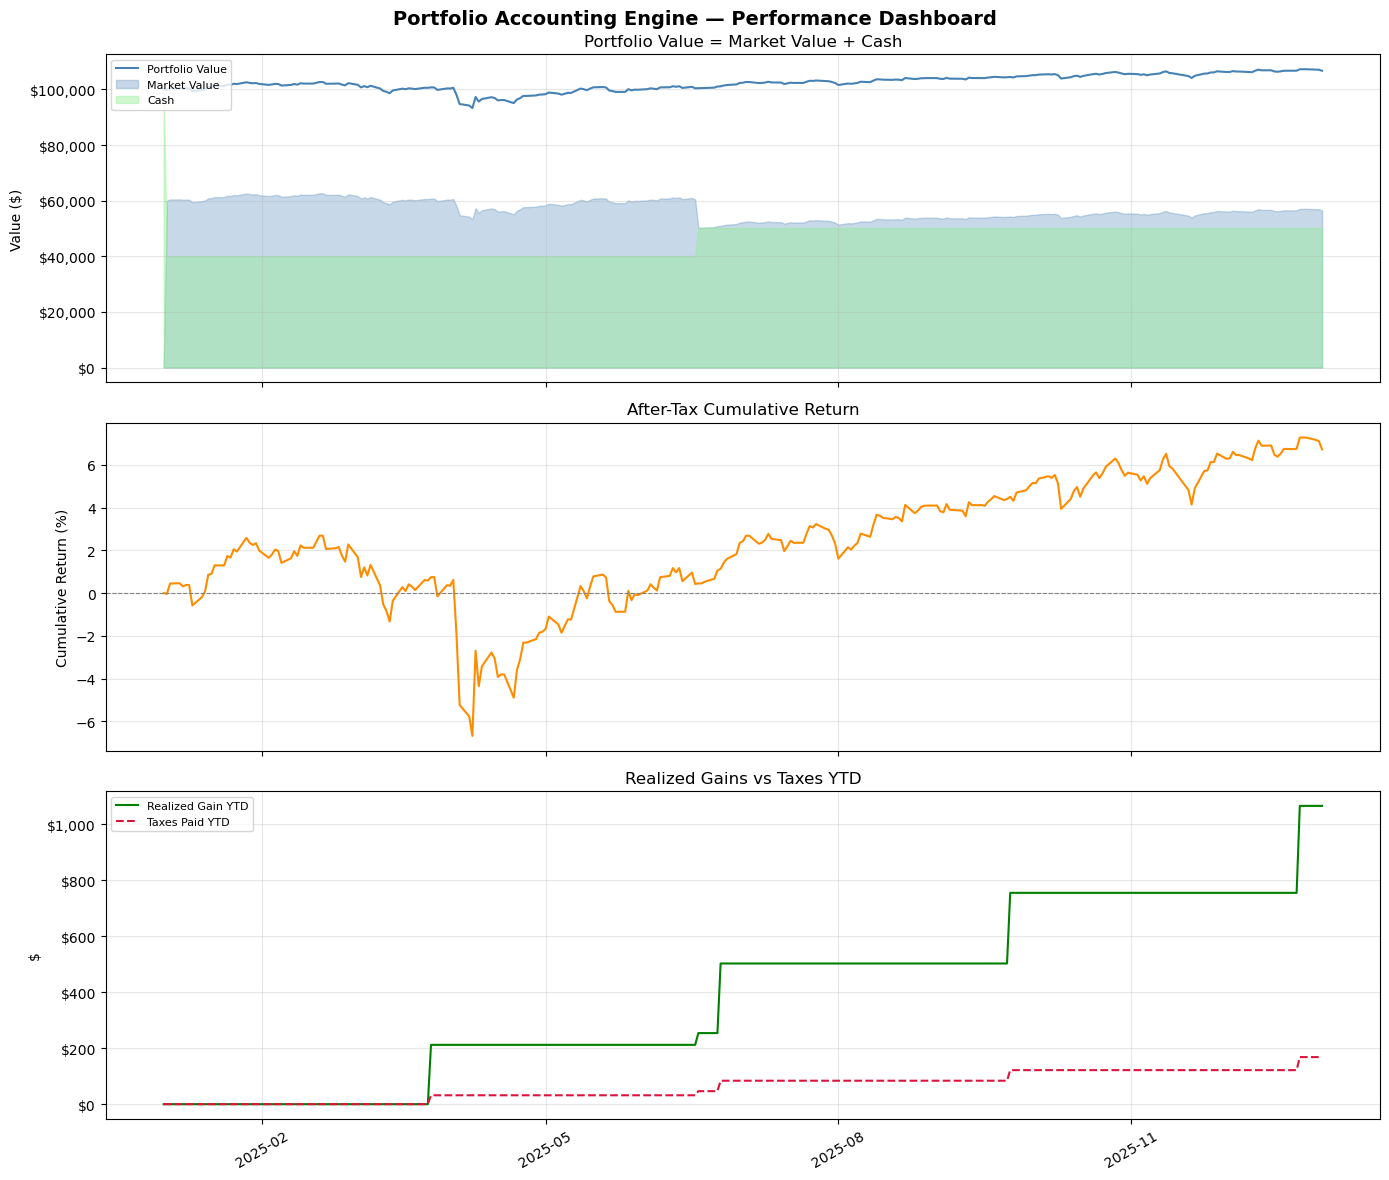

Dashboard saved to portfolio_dashboard.png


In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

nav_df = reporter.nav_summary()

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Portfolio Accounting Engine — Performance Dashboard', fontsize=14, fontweight='bold')

# ── Panel 1: Portfolio Value ────────────────────────────────────────────────
ax1 = axes[0]
ax1.plot(nav_df['date'], nav_df['portfolio_value'], color='steelblue', lw=1.5, label='Portfolio Value')
ax1.fill_between(nav_df['date'], nav_df['market_value'], alpha=0.3, color='steelblue', label='Market Value')
ax1.fill_between(nav_df['date'], nav_df['cash'], alpha=0.4, color='lightgreen', label='Cash')
ax1.set_ylabel('Value ($)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title('Portfolio Value = Market Value + Cash')
ax1.grid(alpha=0.3)

# ── Panel 2: Cumulative Return ──────────────────────────────────────────────
ax2 = axes[1]
ax2.plot(nav_df['date'], nav_df['cumulative_return'] * 100, color='darkorange', lw=1.5)
ax2.axhline(0, color='gray', lw=0.8, linestyle='--')
ax2.set_ylabel('Cumulative Return (%)')
ax2.set_title('After-Tax Cumulative Return')
ax2.grid(alpha=0.3)

# ── Panel 3: Realized Gains vs Taxes YTD ───────────────────────────────────
ax3 = axes[2]
ax3.plot(nav_df['date'], nav_df['realized_ytd'], color='green',  lw=1.5, label='Realized Gain YTD')
ax3.plot(nav_df['date'], nav_df['taxes_ytd'],    color='crimson', lw=1.5, linestyle='--', label='Taxes Paid YTD')
ax3.set_ylabel('$')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax3.set_title('Realized Gains vs Taxes YTD')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('portfolio_dashboard.png', dpi=120, bbox_inches='tight')
plt.show()
print("Dashboard saved to portfolio_dashboard.png")

## Section 11: Architecture Decisions & Assumptions

### Architecture Decisions

**1. Trade-First Design**  
All portfolio state flows from executed trades. There is no return-stream simulation, price-adjustment, or compounding logic. The daily NAV loop reads lot state + prices and computes value from first principles each day.

**2. Lot-Level FIFO Tracking**  
Every buy creates a new lot with its own open date, cost basis, and share count. Sells peel from the oldest lot first. Partial lot disposals are handled by mutating the `shares` field in place. This gives correct holding period classification for ST vs LT gains.

**3. Tax Deduction from Cash**  
Taxes are deducted immediately from `cash` at the moment of realization. This means the portfolio value correctly reflects the after-tax cash balance at all times. There is no deferred tax liability modeling.

**4. Dividend Reinvestment (DRIP)**  
Dividends flow: `gross_div → tax deducted → after_tax_div → DRIP buy trade`. The DRIP buy uses the last available close price with slippage applied. This creates a new lot, so the DRIP shares have a distinct cost basis from the original shares.

**5. No Look-Ahead Bias**  
`_last_price_lookup` filters `prices WHERE PRICEDATE <= as_of`. Only prices known at the time of valuation are used.

**6. Transaction Cost in Cost Basis**  
Slippage and commission are folded into cost basis (`total_acquisition_cost / shares`). This correctly reduces realized gains on sale.

### Assumptions

- **No short selling** — attempting to sell more shares than held clamps to available shares.
- **No margin** — cash cannot go negative (buys are rejected if insufficient cash).
- **Losses do not generate a cash refund** — tax engine returns 0 for losing lots. Extend `TaxEngine.compute_sale_tax` to track loss carry-forwards if needed.
- **Fractional shares are supported** — DRIP trades result in fractional share lots.
- **All dividends are reinvested** — there is no cash-dividend option in this implementation. Remove the `self.buy(...)` call in `process_dividend` and keep `after_tax_div` in cash to support that.
- **Business days only** — the valuation loop runs on `pd.bdate_range`, skipping weekends. Holidays are not removed.
- **Single currency** — USD throughout.
- **Slippage is symmetric** — buys cost more, sells receive less, by the same bps.